# Variational Autoencoder on MNIST dataset

Based on https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776

Also useful as a reference for VAEs is https://jaan.io/what-is-variational-autoencoder-vae-tutorial

## Setup

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

### Get the data

In [2]:
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Define input and output data

MNIST images have a dimension of 28 * 28 pixels with one color channel. Our inputs X_in will be batches of MNIST characters. The network will learn to reconstruct them and output them in a placeholder Y, which has the same dimensions.

In [3]:
tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')

# Used for computation of losses
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])

# Used when applying dropouts; this is set to 0.8 during training, and 1.0 when generating new data
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

# Number of decoder input channels
dec_in_channels = 1

# TODO: What does this do?
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = int(49 * dec_in_channels / 2)
inputs_decoder

24

## Define encoder

In [4]:
def encoder(X_in, keep_prob):
    activation = tf.nn.leaky_relu
    with tf.variable_scope('encoder', reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd = 0.5 * tf.layers.dense(x, units=n_latent)
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent]))
        z = mn + tf.multiply(epsilon, tf.exp(sd))
        return z, mn, sd

## Define decoder

In [5]:
def decoder(sampled_z, keep_prob):
    activation = tf.nn.leaky_relu
    with tf.variable_scope('decoder', reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=activation)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=activation)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.contrib.layers.flatten(x)
        units = 28 * 28
        x = tf.layers.dense(x, units=units, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

## Wire them together

In [6]:
sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)

## Compute losses and enforce Gaussian latent distribution

In [7]:
unreshaped = tf.reshape(dec, [-1, 28 * 28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)

cfg = tf.ConfigProto()
cfg.log_device_placement = True
cfg.gpu_options.allow_growth = True

sess = tf.Session(config=cfg)
sess.run(tf.global_variables_initializer())

## Train the network

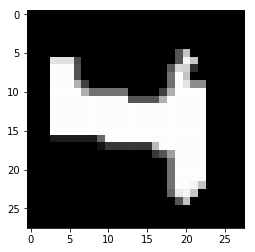

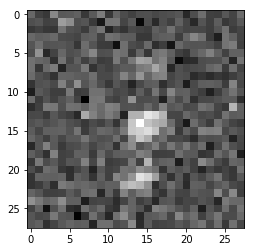

0 177.46573 177.15665 0.30907214


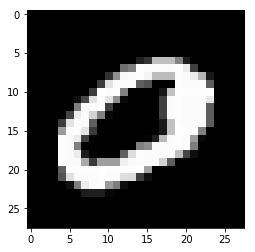

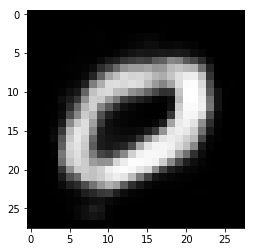

1000 34.822178 25.49815 9.324032


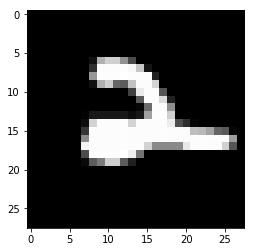

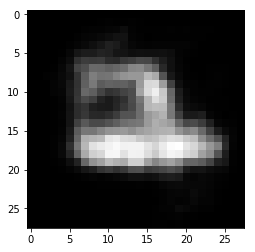

2000 32.3404 22.841286 9.499111


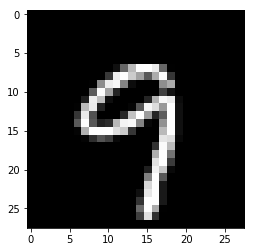

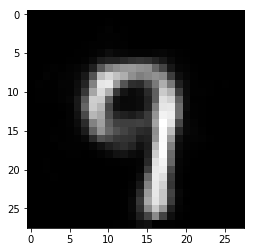

3000 32.357887 22.648495 9.709392


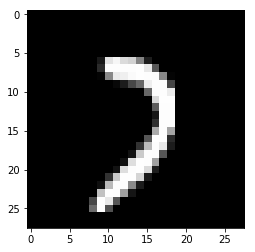

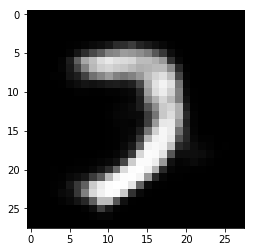

4000 32.469566 22.266724 10.20284


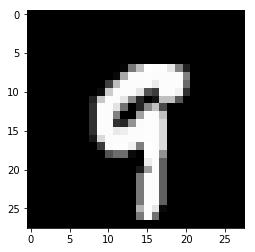

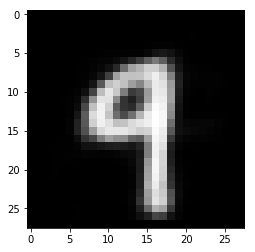

5000 31.333206 21.017216 10.3159895


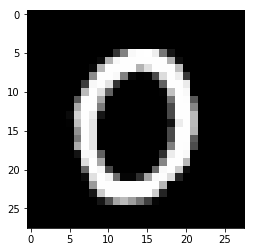

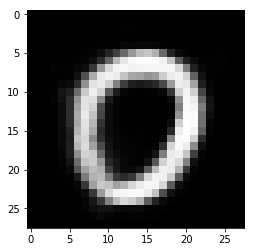

6000 31.212217 21.181103 10.0311165


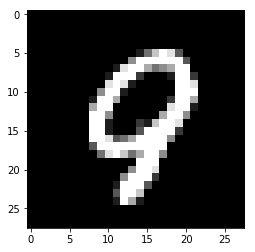

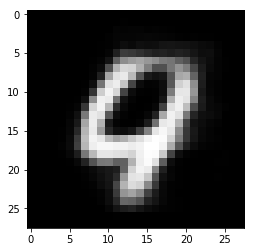

7000 30.139776 19.87664 10.263138


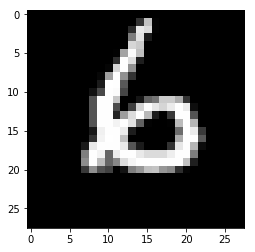

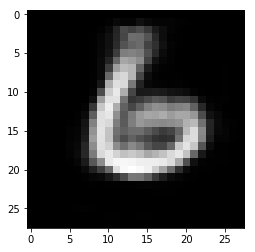

8000 28.66764 18.499996 10.167643


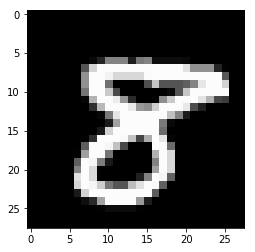

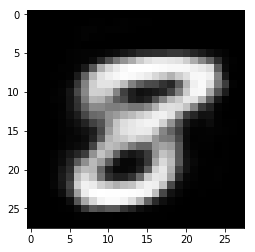

9000 27.95935 18.12673 9.832621


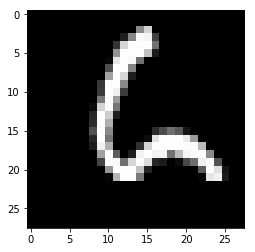

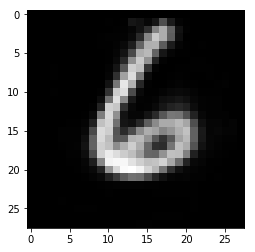

10000 28.82804 18.499691 10.32835


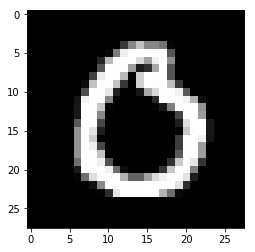

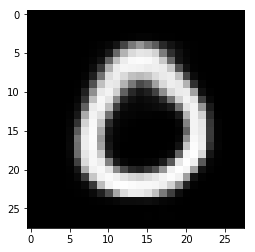

11000 30.378033 20.002274 10.375759


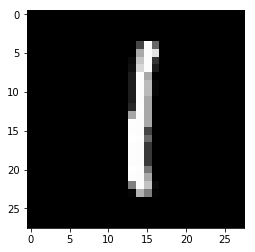

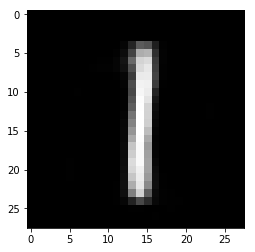

12000 29.491112 19.08643 10.40468


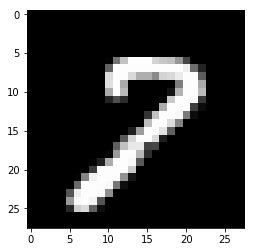

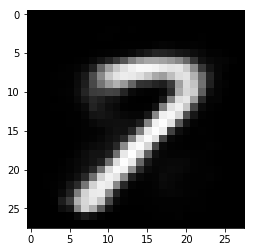

13000 29.776598 19.34262 10.433977


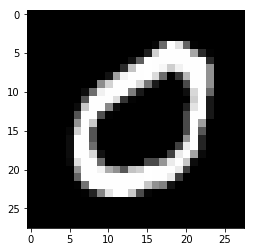

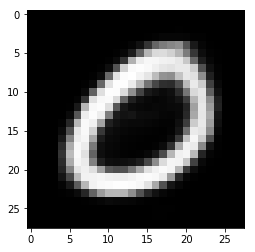

14000 28.08608 17.88712 10.198961


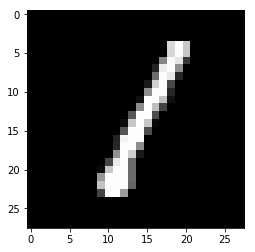

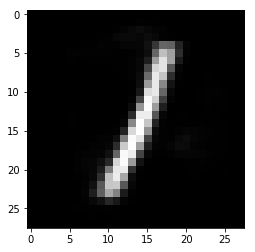

15000 27.629313 17.314785 10.314528


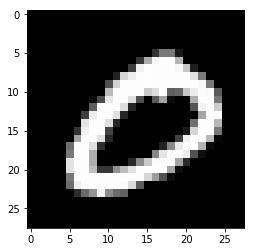

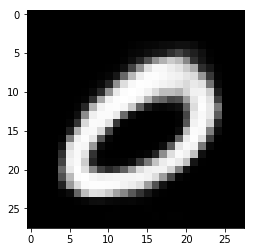

16000 29.80129 19.263601 10.537692


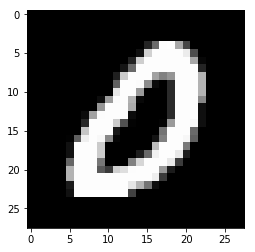

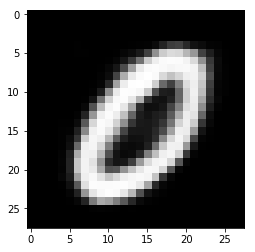

17000 29.457449 19.187714 10.269735


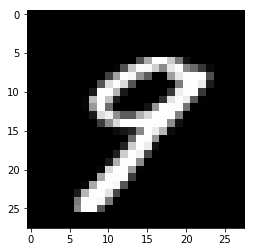

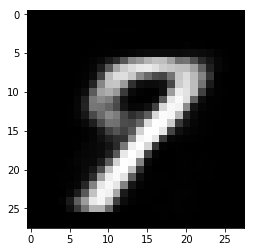

18000 26.437044 15.991125 10.445918


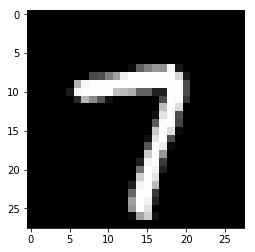

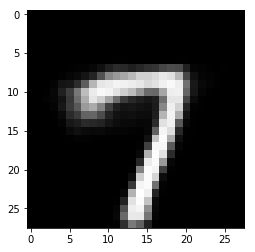

19000 30.49974 20.27967 10.22007


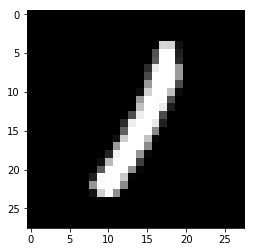

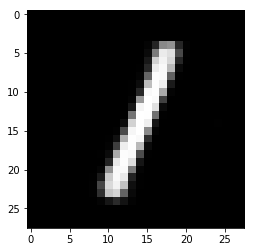

20000 26.834787 16.800434 10.034351


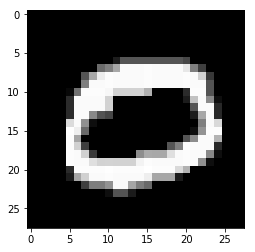

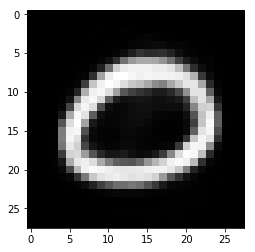

21000 30.32357 20.200945 10.122627


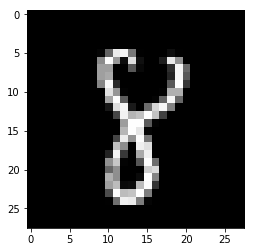

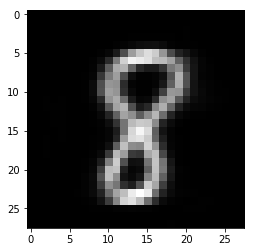

22000 27.339363 17.00599 10.333375


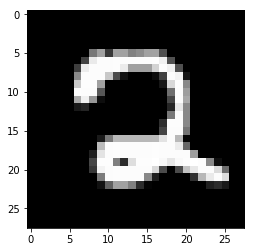

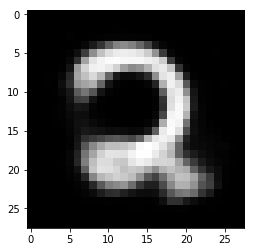

23000 28.198608 17.519491 10.679116


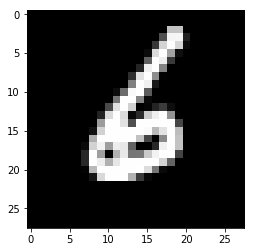

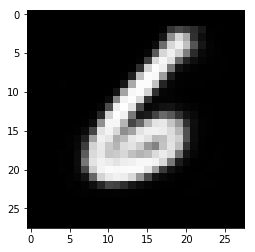

24000 27.52546 17.032127 10.49333


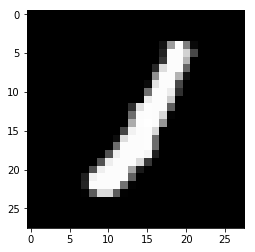

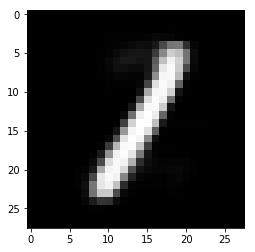

25000 27.325657 16.779064 10.546592


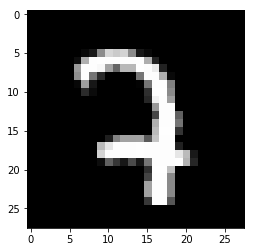

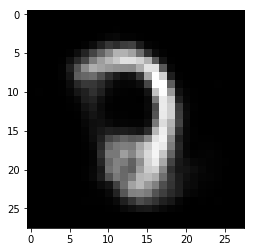

26000 26.484 16.107723 10.376276


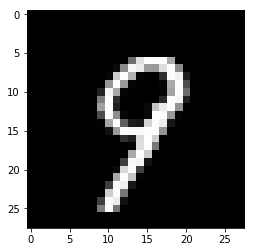

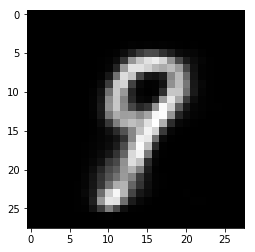

27000 27.871954 17.317986 10.553968


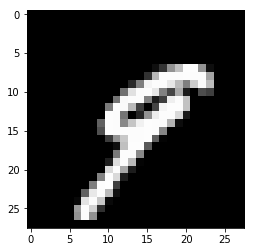

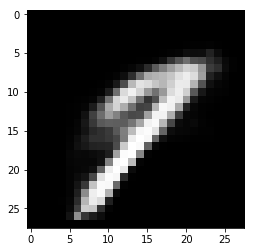

28000 28.38593 17.68609 10.699839


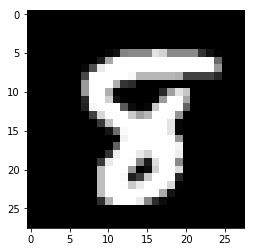

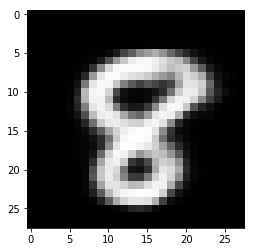

29000 27.995794 17.756542 10.239253


In [8]:
for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict={X_in: batch, Y: batch, keep_prob: 0.8})
    if not i % 1000:
        feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0}
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict=feed_dict)
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))
        

## Generate new data

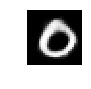

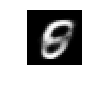

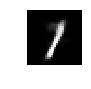

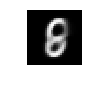

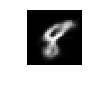

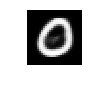

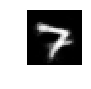

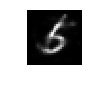

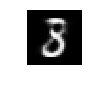

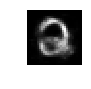

In [9]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict={sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1, 1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')